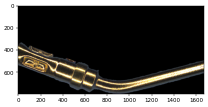

fourpoints:  [[125, 477], [293, 540], [1384, 629], [1552, 584]]
line1:  [125, 477, 293, 540]
line1:  [125, 477, 293, 540]
result:  35.55112495519627 °


35.55112495519627

In [3]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

# 显示图片的函数
def cv_show(name,img):
    cv2.imshow(name,img)
    cv2.waitKey()
    cv2.destroyAllWindows()
    
# 显示彩色图片的函数
def plt_show0(img):
    b,g,r = cv2.split(img)
    img = cv2.merge([r,g,b])
    plt.figure(dpi=40)
    plt.imshow(img)
    plt.show()
    
# 显示灰度图片的函数
def plt_show(img):
    plt.figure(dpi=100)
    plt.imshow(img,cmap='gray')
    plt.show()


# 裁剪完成后进行分割
def image_cut(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    #从上到下，从左到右，不写就是原始的上下左右边界。带 - 号的是从右边或者从下开始计算距离，-10指切去右边缘长度为10的margin
    img = img[:, :-10, :]
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    lower_blue = np.array([100, 43, 46])
    upper_blue = np.array([124, 255, 255])
    #mask：两个阈值内的变白，其他的变黑，返回一个二值化的图像
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
#     plt_show(mask)
    img_morph = mask.copy()
    # 腐蚀膨胀，中值滤波
    core = (3, 3)
    cv2.erode(img_morph, core, img_morph, iterations=4)
#     plt_show(img_morph)
    cv2.dilate(img_morph, core, img_morph, iterations=1)
#     plt_show(img_morph)
    img_morph = cv2.medianBlur(img_morph, 15)
#     plt_show(img_morph)
    res = cv2.findContours(img_morph, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    cnts = res[0] #cnts就是提取到的所有contours组成的list
    
    # sort the elements in contours by the area of a contour, descending order
    cnts_sort = sorted(cnts, key=cv2.contourArea, reverse=True)
    # 生成一个与img相同shape的全0数组white_img
    white_img = np.zeros_like(img)
#     plt_show0(white_img)
    white_img[:, :, :] = 0 #变成一张纯黑的图
    # 第三个参数0代表：绘制cnts_sort里的第一个contour
    # 最后一个参数-1代表：绘制contour时，填充轮廓内部
    cv2.drawContours(white_img, cnts_sort, 0, (255, 255, 255), -1) #会在白底上画出黑色的区域
#     plt_show0(white_img)
    black_img = np.zeros_like(img)
    black_img[:, :, :] = 255 #变成一张纯白的图
#     plt_show0(black_img)
    black_img_copy = cv2.cvtColor(black_img, cv2.COLOR_BGR2GRAY)#变成了一张纯黑的图
#     plt_show(black_img_copy)
    cv2.drawContours(black_img_copy, cnts_sort, 0, (0, 0, 0), -1) #这里的颜色只要不是(255, 255, 255)，就都是白色；(255, 255, 255)画出黑色
#     cv2.imwrite('black_img.png', black_img_copy)
#     plt_show(black_img_copy)
    res = cv2.findContours(black_img_copy, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

#     cv2.imwrite('black_img.png', black_img_copy)
    img_copy = img.copy()
    cv2.drawContours(img_copy, res[0][0], -1, (0, 255, 0), 10)
#     cv2.imwrite('img_copy.png', img_copy)
#     plt_show0(img_copy)
    x, y, w, h = cv2.boundingRect(res[0][0])
    pure_img = img.copy()
    # 获得方框
    cv2.rectangle(pure_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
#     cv2.imwrite('pure_img.png', pure_img)
#     plt_show0(pure_img)
    ## 灰度图
    gray_pure_img = cv2.cvtColor(pure_img, cv2.COLOR_BGR2GRAY)
#     cv2.imwrite('gray_pure_img.png', gray_pure_img)
#     plt_show(gray_pure_img)
    # 裁剪
    cuted_image = img[y:y + h, x:x + w]
#     cv2.imwrite('cuted_image.png', cuted_image)
#     plt_show0(cuted_image)
    bounding = res[0][0] # 最大的contour
    
    #让contour的所有点的坐标移动，以配合裁剪出来的新图片
    def bounding_move(bounding_point):
        bounding_point[0, 0] -= x #裁剪范围的左上角的x坐标
        bounding_point[0, 1] -= y
        return bounding_point

    bounding = np.array(list(map(bounding_move, bounding)))
    return cuted_image, bounding

def fill_black(image, bounding):
    stencil = np.zeros(image.shape).astype(image.dtype)
#     plt_show0(stencil)
    color = (255, 255, 255)
    cv2.fillPoly(stencil, [bounding], color)
#     plt_show0(stencil)
#     plt_show0(image)
    result = cv2.bitwise_and(image, stencil)
#     plt_show0(result)
    return result


def vector_angle(line1: list, line2: list):
    """
    计算两条直线的夹角，
    :param line1: 直线一[x1, y1, x2, y2]
    :param line2: 直线二 [x1, y1, x2, y2]
    :return:
    """

    vector1 = np.array([line1[2] - line1[0], line1[3] - line1[1]])  # (x2-x1,y2-y1)
    vector2 = np.array([line2[2] - line2[0], line2[3] - line2[1]])
    return np.arccos(
        vector1 @ vector2 / (np.linalg.norm(vector1) * np.linalg.norm(vector2)))


def delete_white(rawImage):

#     plt_show0(rawImage)
    # 高斯去噪
    image = cv2.GaussianBlur(rawImage, (3,3), 0)
    # plt_show0(image)

    height, width, color = image.shape

    image_hsv = image.copy()
    image_hsv =  cv2.cvtColor(image_hsv, cv2.COLOR_RGB2HSV)

    lower_blue = np.array([0, 0, 180])
    upper_blue = np.array([180, 255, 255])
    #mask：两个阈值内的变白，其他的变黑，返回一个二值化的图像
    mask = cv2.inRange(image_hsv, lower_blue, upper_blue)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    # plt_show0(mask)

    stencil = cv2.bitwise_not(mask)
    # plt_show0(stencil)

    image = cv2.bitwise_and(image, stencil)
    # plt_show0(image)

    xPosition = 0
    for x in range(0,width,5):
        cnt = 0
        for y in range(0, height):
            if image[y][x][0] > 0:
                cnt += 1
        if cnt > 125:
            xPosition = x
            break
#     print("xPos",xPosition)
    return xPosition


def get_two_lines(fill_black_right):
    height, width, color = fill_black_right.shape
    fill_black_right_HSV = cv2.cvtColor(fill_black_right, cv2.COLOR_BGR2HSV)

    # left 1 ---------------------------------------
    left_1_middle_y_1 = 0
    left_1_middle_y_2 = 0
    left_1_middle_y = 0
    left_1_start_x = width//20
    left_1_end_x = width//10
    cnt = 0
    cnt_2 = 0
    for x in range(left_1_start_x,left_1_end_x,5):
        for y in range(0, height):
            if fill_black_right_HSV[y][x][2] != 0:
                cnt += 1
                left_1_middle_y_1 += y
                break
        for k in range(height-1, 0, -1):
            if fill_black_right_HSV[k][x][2] != 0:
                cnt_2 += 1
                left_1_middle_y_2 += k
                break
    left_1_middle_y_1 = left_1_middle_y_1//cnt
    left_1_middle_y_2 = left_1_middle_y_2//cnt_2

    # print(left_1)
    left_1_middle_x = (left_1_start_x + left_1_end_x)//2
    left_1_middle_y = (left_1_middle_y_1 + left_1_middle_y_2)//2
#     print(left_1_middle_x,left_1_middle_y)

    #left 2 ------------------------------------------
    left_2_middle_y = 0
    left_2_middle_y_1 = 0
    left_2_middle_y_2 = 0
    left_2_start_x = 3 * width//20
    left_2_end_x = width//5
    cnt = 0
    cnt_2 = 0
    for x in range(left_2_start_x,left_2_end_x,5):
        for y in range(0, height):
            if fill_black_right_HSV[y][x][2] != 0:
                cnt += 1
                left_2_middle_y_1 += y
                break
        for k in range(height-1, 0, -1):
            if fill_black_right_HSV[k][x][2] != 0:
                cnt_2 += 1
                left_2_middle_y_2 += k
                break
    left_2_middle_y_1 = left_2_middle_y_1//cnt
    left_2_middle_y_2 = left_2_middle_y_2//cnt_2


    # print(left_1)
    left_2_middle_x = (left_2_start_x + left_2_end_x)//2
    left_2_middle_y = (left_2_middle_y_1 + left_2_middle_y_2)//2
#     print(left_2_middle_x,left_2_middle_y)


    #right 1 ------------------------------------------
    right_1 = []
    right_1_middle_y = 0
    right_1_middle_y_1 = 0
    right_1_middle_y_2 = 0
    right_1_start_x = width - width//5
    right_1_end_x = width - 3 * width//20
    cnt = 0
    cnt_2 = 0
    for x in range(right_1_start_x,right_1_end_x,5):
        for y in range(0, height):
            if fill_black_right_HSV[y][x][2] != 0:
                cnt += 1
                right_1_middle_y_1 += y
                break
        for k in range(height-1, 0, -1):
            if fill_black_right_HSV[k][x][2] != 0:
                cnt_2 += 1
                right_1_middle_y_2 += k
                break
    right_1_middle_y_1 = right_1_middle_y_1//cnt
    right_1_middle_y_2 = right_1_middle_y_2//cnt_2

    right_1_middle_x = (right_1_start_x + right_1_end_x)//2
    right_1_middle_y = (right_1_middle_y_1 + right_1_middle_y_2)//2
#     print(right_1_middle_x,right_1_middle_y)

    #right 2 ------------------------------------------
    right_2 = []
    right_2_middle_y = 0
    right_2_middle_y_1 = 0
    right_2_middle_y_2 = 0
    right_2_start_x = width - width//10
    right_2_end_x = width - width//20
    cnt = 0
    cnt_2 = 0
    for x in range(right_2_start_x,right_2_end_x,5):
        for y in range(0, height):
            if fill_black_right_HSV[y][x][2] != 0:
                cnt += 1
                right_2_middle_y_1 += y
                break
        for k in range(height-1, 0, -1):
            if fill_black_right_HSV[k][x][2] != 0:
                cnt_2 += 1
                right_2_middle_y_2 += k
                break
    right_2_middle_y_1 = right_2_middle_y_1//cnt
    right_2_middle_y_2 = right_2_middle_y_2//cnt_2

    right_2_middle_x = (right_2_start_x + right_2_end_x)//2
    right_2_middle_y = (right_2_middle_y_1 + right_2_middle_y_2)//2
#     print(right_2_middle_x,right_2_middle_y)
    return [[left_1_middle_x,left_1_middle_y],[left_2_middle_x,left_2_middle_y],[right_1_middle_x,right_1_middle_y],[right_2_middle_x,right_2_middle_y]]


def if_bend(img_dir):
    cuted_image, bounding = image_cut(img_dir)
    fill_b = fill_black(cuted_image, bounding)
    xPosition = delete_white(fill_b)
    margin = 50
    height, width, color = fill_b.shape
    fill_black_right = fill_b[0:height,xPosition+margin:width-margin]

    plt_show0(fill_black_right)
    fourpoints = get_two_lines(fill_black_right)

    print("fourpoints: ",fourpoints)

    line1 = [fourpoints[0][0],fourpoints[0][1], fourpoints[1][0],fourpoints[1][1]]
    line2 = [fourpoints[2][0],fourpoints[2][1], fourpoints[3][0],fourpoints[3][1]]
    
    print("line1: ",line1)
    print("line1: ",line1)

    a = vector_angle(line1,line2)
    # print(a)
    pi = 3.1415926
    result = a/pi*180
    print("result: ",result,"°")
    return result

import datetime
start = datetime.datetime.now()

# img_dir_single = r"F:/python/tubeBending/tubeBendingImage/tif/strange.tif"
# if_bend(img_dir_single)

# 改成自己的图片路径
# img_dir = r"/Users/zhouxinyu/Code/Python/jupyter/Project/ZF/main/弯曲检测/data/"
# img_dir_list = []
# for i in range(0,150):
#     img_dir_list.append(img_dir)
#     if i < 10:
#         img_dir_list[i] += '0'
#     img_dir_list[i] += str(i) + '.tif'
#     print(img_dir_list[i])
#     if_bend(img_dir_list[i])
#     print('\n')

# end = datetime.datetime.now()
# print(end - start)
if_bend("/Users/zhouxinyu/Code/Python/jupyter/Project/ZF/main/弯曲检测/data/0.tif")

